<a href="https://colab.research.google.com/github/ritwiks9635/Mini-Agentic-AI/blob/main/Agentic_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI Engineer Assignment**

In [ ]:
!pip install langchain
!pip install langgraph
!pip install pinecone-client[grpc]
!pip install -U langsmith
!pip install pypdf
!pip install streamlit
!pip install -U langchain-community
!pip install -qU langchain-pinecone

In [ ]:
%pip install -U -q "google-generativeai>=0.8.3"
%pip install --upgrade --quiet  langchain-google-genai

In [ ]:
import os
import json
import requests
import numpy as np
import langchain
import langgraph
from langgraph.graph import Graph
from langgraph.graph import StateGraph

from langsmith import traceable, Client
from pydantic import BaseModel, Field

from typing import TypedDict, Optional
from langchain.prompts import PromptTemplate

import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader


from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.schema import Document

In [ ]:
from langsmith import traceable, Client

## **Setup Pinecone**

In [ ]:
# Create Pinecone index
index_name = 'qa-bot'
PINE_API_KEY = os.getenv("PINECONE_API_KEY")
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(api_key=PINE_API_KEY)

pc.create_index(
    name=index_name,
    dimension=768,
    metric='cosine',
    spec=ServerlessSpec(
      cloud="aws",
      region="us-east-1"
    )
  )

index = pc.Index(index_name)

### **Build LangGraph Node**

In [ ]:
class PipelineState(TypedDict):
    user_query: str
    action: Optional[str]
    response: Optional[str]

In [ ]:
def decision_node(state: PipelineState):
    query = state["user_query"]

    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

    classification_prompt = f"""
    Classify this query as either 'weather', 'rag', or 'general'.
    - If it is asking about weather conditions, classify as 'weather'.
    - If it is asking about information from a provided document, classify as 'rag'.
    - If the query does not fit into these categories, classify as 'general'.

    Query: {query}
    """

    action = llm.invoke(classification_prompt)

    # Ensure action is valid
    action_str = action.content.lower()
    if action_str not in ["weather", "rag", "general"]:
        action_str = "general"
    else :
        action_str = action.content.lower()

    return {"action": action_str}

### **Weather API Call**

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0)

# Prompt template for extracting city name
city_extraction_prompt = PromptTemplate.from_template(
    "Extract the city name from this query: {query}. If no city is found, return 'None'."
)

def fetch_weather(state: PipelineState):
    user_query = state["user_query"]

    # Ask Gemini LLM to extract the city name
    prompt = city_extraction_prompt.format(query=user_query)
    city = llm.invoke(prompt)

    if city.content.lower() == "none":
        return {"response": "I couldn't determine the city name. Please specify a valid location."}

    api_key = os.getenv("OPENWEATHER_API_KEY")
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city.content}&appid={api_key}&units=metric"

    response = requests.get(url).json()

    if response.get("main"):
        weather_info = f"Current weather in {city.content}: {response['weather'][0]['description']}, Temperature: {response['main']['temp']}°C."
    else:
        weather_info = "Weather data not available. Please check the city name."

    return {"response": weather_info}

In [ ]:
# Load PDF
def load_and_split_pdf(pdf_path):
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Split documents into smaller chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = text_splitter.split_documents(documents)

    return docs

###  **Generate Embeddings**

In [ ]:
import time

def get_gemini_embeddings(texts, batch_size = 10):
    model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", task_type="retrieval_document")
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]

        try:
            response = model.embed_documents(batch)
            batch_embeddings = [item for item in response]
            embeddings.extend(batch_embeddings)

        except Exception as e:
            print(f"Error in batch {i}: {e}")
            time.sleep(5)
    return np.array(embeddings)

### **Strore Embedding in Pinecone**

In [ ]:
def store_in_pinecone(docs):
    texts = [doc.page_content for doc in docs]
    embeddings = get_gemini_embeddings(texts)

    # Store vectors in Pinecone
    for i, (text, vector) in enumerate(zip(texts, embeddings)):
        index.upsert([(str(i), vector.tolist(), {"text": text})])

    print("Stored documents in Pinecone successfully!")

In [ ]:
pdf_path = "/content/Gen AI Engineer - Machine Learning Engineer Assignment.pdf"
docs = load_and_split_pdf(pdf_path)
store_in_pinecone(docs)

Stored documents in Pinecone successfully!


### **Build RAG Pipeline**

In [ ]:
llm_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

def get_gemini_embedding(query):
    """Generate embeddings for the user query."""
    model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", task_type="retrieval_query")
    embedding = model.embed_query(query)
    return np.array(embedding)

def retrieve_relevant_docs(query, top_k=3):
    """Retrieve the most relevant documents from Pinecone."""
    query_vector = get_gemini_embedding(query).tolist()
    results = index.query(vector=query_vector, top_k=top_k, include_metadata=True)

    # Extract relevant texts
    retrieved_texts = [match["metadata"]["text"] for match in results["matches"]]

    return retrieved_texts

def generate_rag_response(query):
    """Use RAG to fetch relevant documents and generate an answer."""
    retrieved_docs = retrieve_relevant_docs(query)
    docs = "\n\n".join(retrieved_docs)

    # Generate response using Gemini LLM
    instructions = f"""You are a helpful assistant who is good at analyzing source information and answering questions.
    Use the following source documents to answer the user's questions.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.

    Documents:
    {docs}"""

    response = llm_model.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": query},
        ],
    )
    return response.content

In [ ]:
query = "which type of dataset required to build this question answering model?"
response = generate_rag_response(query)
print("Generated Answer:\n", response)

Generated Answer:
 A Profit & Loss (P&L) table extracted from PDF documents is needed.  The model also uses a vector database to store embeddings of financial terms and insights.  This allows for efficient retrieval of relevant information.


In [ ]:
def retrieve_from_pinecone(state: PipelineState):
    query = state["user_query"]

    # Load Pinecone as the retriever
    responce = generate_rag_response(query)

    return {"response": response}

### **General Response**

In [ ]:
def general_response(state: PipelineState):
    query = state["user_query"]

    instructions = f"""
    You are a helpful assistant, as a professional expert,
    provide a concise and informative answer to the following question,
    ensuring accuracy and addressing all relevant aspects, even if the
    question appears broad or open-ended. Answer the following Question concisely.
    """

    llm_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

    response = llm_model.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": query},
        ],
    )
    return {"response": response.content}

In [ ]:
# Create LangGraph workflow
workflow = StateGraph(PipelineState)

# Add nodes
workflow.add_node("decision", decision_node)
workflow.add_node("weather", fetch_weather)
workflow.add_node("rag", retrieve_from_pinecone)
workflow.add_node("general", general_response)

# Define edges (execution flow)
workflow.set_entry_point("decision")
workflow.add_conditional_edges(
    "decision",
    lambda state: state["action"],
    {
        "weather": "weather",
        "rag": "rag",
        "general": "general",
    }
)

# Finalize the graph
graph = workflow.compile()

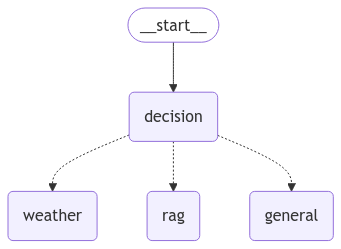

In [ ]:
graph

### **Test LangGraph Performance**

In [ ]:
user_input = "What is the weather in Durgapur?"

state = {"user_query": user_input, "action": None, "response": None}
output = graph.invoke(state)
print(output)

{'user_query': 'What is the weather in Durgapur?', 'action': 'weather', 'response': 'Current weather in Durgapur: few clouds, Temperature: 28.65°C.'}


In [ ]:
user_input = "which type of dataset required to build this question answering model in this pdf?"

state = {"user_query": user_input, "action": None, "response": None}
output = graph.invoke(state)
print(output)

{'user_query': 'which type of dataset required to build this question answering model in this pdf?', 'action': 'rag', 'response': 'A Profit & Loss (P&L) table extracted from PDF documents is needed.  The model also uses a vector database to store embeddings of financial terms and insights.  This allows for efficient retrieval of relevant information.'}


In [ ]:
user_input = "What is Machine Learning"

state = {"user_query": user_input, "action": None, "response": None}
output = graph.invoke(state)
print(output)

{'user_query': 'What is Machine Learning', 'action': 'general', 'response': 'Machine learning (ML) is a subfield of artificial intelligence (AI) that focuses on enabling computer systems to learn from data without explicit programming.  Instead of relying on pre-programmed rules, ML algorithms identify patterns, make predictions, and improve their performance over time based on the data they are exposed to.  This learning process can be supervised (using labeled data), unsupervised (using unlabeled data), or reinforcement learning (using rewards and penalties).  ML powers numerous applications, including image recognition, natural language processing, and recommendation systems.'}


## **Evaluate Q & A model**

In [23]:
# Initialize LangChain LLM
llm_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=1)

# Define the RAG bot function
@traceable()
def rag_bot(question: str) -> dict:
    docs = retrieve_relevant_docs(question)
    docs_string = "\n\n".join(docs)

    instructions = f"""You are a helpful assistant who is good at analyzing source information and answering questions.
    Use the following source documents to answer the user's questions.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.

    Documents:
    {docs_string}"""

    ai_msg = llm_model.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": question},
        ],
    )

    return {"answer": ai_msg.content, "documents": docs}

# Initialize LangSmith client
client = Client()

# Create dataset and examples
dataset_name = "Q&A Model for Evaluation "
dataset = client.create_dataset(dataset_name=dataset_name)

examples = [
    ("What the main goal in this PDF assignment?",
     "The main goal of this PDF assignment is to build a question-answering (QA) bot that can accurately answer questions about financial data extracted from P&L tables within PDF documents.  This involves two parts:  first, developing a Retrieval-Augmented Generation (RAG) model to efficiently retrieve relevant financial information; and second, creating an interactive user interface allowing users to upload PDFs, ask questions, and receive answers alongside supporting data from the document.."),
    ("What platform use to build this question answering model in this PDF assignment?",
     "The provided text doesn't specify the platform used to build the question-answering model.  It mentions using a vector database like Pinecone for storing and retrieving embeddings, and it describes the functionality of a RAG model, but it doesn't state the specific platform (e.g., Python with specific libraries, a cloud-based platform like AWS or Google Cloud, etc.) used for its development."),
    ("which type of dataset required to build this question answering model?",
     "A Profit & Loss (P&L) table extracted from PDF documents is the required dataset.  The model uses this data to answer financial questions.  The P&L table should contain information on income, expenses, and profit margins."),
]

client.create_examples(
    inputs=[{"question": q} for q, _ in examples],
    outputs=[{"answer": a} for _, a in examples],
    dataset_id=dataset.id,
)

### Define Evaluators

# Correctness Evaluation
class CorrectnessGrade(BaseModel):
    explanation: str = Field(description = "Explain your reasoning for the score")
    correct: bool = Field(description = "True if the answer is correct, False otherwise.")

correctness_instructions = """You are a teacher grading a quiz.
Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer.
A correctness value of True means the answer is correct. False means it is not. Explain your reasoning."""

llm_grader = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0).with_structured_output(CorrectnessGrade)

def correctness(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    answers = f"""QUESTION: {inputs['question']}
    GROUND TRUTH ANSWER: {reference_outputs['answer']}
    STUDENT ANSWER: {outputs['answer']}"""

    grade = llm_grader.invoke([{"role": "system", "content": correctness_instructions}, {"role": "user", "content": answers}])
    return grade.correct

# Relevance Evaluation
class RelevanceGrade(BaseModel):
    explanation: str = Field(description = "Explain your reasoning for the score")
    relevant: bool = Field(description = "True if the answer is relevant to the question")

relevance_instructions = """You are a teacher grading a quiz.
Ensure the student's answer is concise and relevant to the question.
A relevance value of True means the answer meets these criteria; False means it does not."""

relevance_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0).with_structured_output(RelevanceGrade)

def relevance(inputs: dict, outputs: dict) -> bool:
    answer = f"""QUESTION: {inputs['question']}
STUDENT ANSWER: {outputs['answer']}"""

    grade = relevance_llm.invoke([{"role": "system", "content": relevance_instructions}, {"role": "user", "content": answer}])
    return grade.relevant

# Groundedness Evaluation
class GroundedGrade(BaseModel):
    explanation: str = Field(description = "Explain your reasoning for the score")
    grounded: bool = Field(description = "True if the answer is based on the provided documents")

grounded_instructions = """You are a teacher grading a quiz.
Ensure the student's answer is grounded in the provided documents and does not include hallucinated information.
A grounded value of True means the answer is well-supported; False means it is not."""

grounded_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0).with_structured_output(GroundedGrade)

def groundedness(inputs: dict, outputs: dict) -> bool:
    doc_string = "\n".join(doc for doc in outputs["documents"])
    answer = f"""FACTS: {doc_string}
STUDENT ANSWER: {outputs['answer']}"""

    grade = grounded_llm.invoke([{"role": "system", "content": grounded_instructions}, {"role": "user", "content": answer}])
    return grade.grounded

# Define the evaluation target
def target(inputs: dict) -> dict:
    return rag_bot(inputs["question"])

# Run the evaluation
experiment_results = client.evaluate(
    target,
    data=dataset_name,
    evaluators=[correctness, relevance, groundedness],
    experiment_prefix="rag-doc-relevance",
    metadata={"version": "1.0"}
)

View the evaluation results for experiment: 'rag-doc-relevance-0d6084b8' at:
https://smith.langchain.com/o/1a930940-6f2b-4a80-a11b-277499a43884/datasets/e79890b3-b7d9-4b01-b4f4-d3646bb3d00b/compare?selectedSessions=7b29503f-fd16-44b5-9aae-c6deb4c5733d




0it [00:00, ?it/s]

### **Test Cases**

In [ ]:
!pip install pytest

In [24]:
os.makedirs("pipeline")
os.makedirs("test")

In [26]:
%%writefile /content/pipeline/pipeline.py
import os
import json
import time
import requests
import numpy as np
import langchain
import langgraph
from dotenv import load_dotenv
from langgraph.graph import Graph
from langgraph.graph import StateGraph

from langsmith import traceable, Client
from pydantic import BaseModel, Field

from typing import TypedDict, Optional
from langchain.prompts import PromptTemplate

import google.generativeai as genai

from langchain_pinecone import PineconeVectorStore
from langchain_community.document_loaders import PyPDFLoader

# Import the required classes directly
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.schema import Document

index_name = 'qa-bot'
PINE_API_KEY = os.getenv("PINECONE_API_KEY")
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(api_key=PINE_API_KEY)
index = pc.Index(index_name)

class PipelineState(TypedDict):
    user_query: str
    action: Optional[str]
    response: Optional[str]

def decision_node(state: PipelineState):
    query = state["user_query"]

    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

    classification_prompt = f"""
    Classify this query as either 'weather', 'rag', or 'general'.
    - If it is asking about weather conditions, classify as 'weather'.
    - If it is asking about information from a provided document, classify as 'rag'.
    - If the query does not fit into these categories, classify as 'general'.

    Query: {query}
    """

    action = llm.invoke(classification_prompt)

    # Ensure action is valid
    action_str = action.content.lower()
    if action_str not in ["weather", "rag", "general"]:
        action_str = "general"
    else:
        action_str = action.content.lower()

    return {"action": action_str}

def fetch_weather(state: PipelineState):
    user_query = state["user_query"]

    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0)
    # Prompt template for extracting city name
    city_extraction_prompt = PromptTemplate.from_template(
        "Extract the city name from this query: {query}. If no city is found, return 'None'."
    )
    # Ask Gemini LLM to extract the city name
    prompt = city_extraction_prompt.format(query=user_query)
    city = llm.invoke(prompt)

    if city.content.lower() == "none":
        return {"response": "I couldn't determine the city name. Please specify a valid location."}

    api_key = os.getenv("OPENWEATHER_API_KEY")
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city.content}&appid={api_key}&units=metric"

    response = requests.get(url).json()

    if response.get("main"):
        weather_info = f"Current weather in {city.content}: {response['weather'][0]['description']}, Temperature: {response['main']['temp']}°C."
    else:
        weather_info = "Weather data not available. Please check the city name."

    return {"response": weather_info}


def load_and_split_pdf(pdf_path):
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Split documents into smaller chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = text_splitter.split_documents(documents)

    return docs

def get_gemini_embeddings(texts, batch_size = 10):
    model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", task_type="retrieval_document")
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]

        try:
            response = model.embed_documents(batch)
            batch_embeddings = [item for item in response]
            embeddings.extend(batch_embeddings)

        except Exception as e:
            print(f"Error in batch {i}: {e}")
            time.sleep(5)
    return np.array(embeddings)


def store_in_pinecone(docs):
    texts = [doc.page_content for doc in docs]
    embeddings = get_gemini_embeddings(texts)

    # Store vectors in Pinecone
    for i, (text, vector) in enumerate(zip(texts, embeddings)):
        index.upsert([(str(i), vector.tolist(), {"text": text})])
    print("Stored documents in Pinecone successfully!")

def get_gemini_embedding(query):
    """Generate embeddings for the user query."""
    model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", task_type="retrieval_query")
    embedding = model.embed_query(query)
    return np.array(embedding)

def retrieve_relevant_docs(query, top_k=3):
    """Retrieve the most relevant documents from Pinecone."""
    query_vector = get_gemini_embedding(query).tolist()
    results = index.query(vector=query_vector, top_k=top_k, include_metadata=True)

    # Extract relevant texts
    retrieved_texts = [match["metadata"]["text"] for match in results["matches"]]

    return retrieved_texts


def generate_rag_response(query):
    """Use RAG to fetch relevant documents and generate an answer."""
    retrieved_docs = retrieve_relevant_docs(query)
    docs = "\n\n".join(retrieved_docs)

    # Generate response using Gemini LLM
    instructions = f"""You are a helpful assistant who is good at analyzing source information and answering questions.
    Use the following source documents to answer the user's questions.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.

    Documents:
    {docs}"""

    llm_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")
    response = llm_model.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": query},
        ],
    )
    return response.content

def retrieve_from_pinecone(state: PipelineState):
    query = state["user_query"]

    # Load Pinecone as the retriever
    response = generate_rag_response(query)

    return {"response": response}

def general_response(state: PipelineState):
    query = state["user_query"]

    instructions = f"""
    You are a helpful assistant, as a professional expert,
    provide a concise and informative answer to the following question,
    ensuring accuracy and addressing all relevant aspects, even if the
    question appears broad or open-ended. Answer the following Question concisely.
    """

    llm_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

    response = llm_model.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": query},
        ],
    )
    return {"response": response.content}


# Create LangGraph workflow
workflow = StateGraph(PipelineState)

# Add nodes
workflow.add_node("decision", decision_node)
workflow.add_node("weather", fetch_weather)
workflow.add_node("rag", retrieve_from_pinecone)
workflow.add_node("general", general_response)

# Define edges (execution flow)
workflow.set_entry_point("decision")
workflow.add_conditional_edges(
    "decision",
    lambda state: state["action"],
    {
        "weather": "weather",
        "rag": "rag",
        "general": "general",
    }
)

# Finalize the graph
graph = workflow.compile()

Writing /content/pipeline/pipeline.py


In [27]:
%%writefile test/test_pipeline.py
import pytest
from unittest.mock import patch, MagicMock
import sys
import os

# Add the project root to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# Import the pipeline module
from pipeline.pipeline import (
    decision_node, fetch_weather, retrieve_from_pinecone,
    general_response, get_gemini_embedding, generate_rag_response, retrieve_relevant_docs
)

### TEST CASES ###

def test_decision_node():
    """Test classification of user queries into correct categories."""
    test_cases = [
        ("What's the weather in New York?", "weather"),
        ("Tell me about quantum physics.", "general"),
        ("Summarize this document.", "rag")
    ]

    for query, expected_action in test_cases:
        state = {"user_query": query}
        result = decision_node(state)
        assert result["action"] == expected_action, f"Failed for query: {query}"

@patch("pipeline.pipeline.requests.get")
def test_fetch_weather(mock_get):
    """Test weather API response handling."""
    mock_get.return_value.json.return_value = {
        "main": {"temp": 22.5},
        "weather": [{"description": "clear sky"}]
    }

    state = {"user_query": "What is the weather in London?"}
    result = fetch_weather(state)

    assert "London" in result["response"]
    assert "clear sky" in result["response"]
    assert "22.5°C" in result["response"]

@patch("pipeline.pipeline.GoogleGenerativeAIEmbeddings.embed_query")
def test_get_gemini_embedding(mock_embed):
    """Ensure query embeddings return correct shape."""
    mock_embed.return_value = [0.1] * 768  # Mock embedding vector
    embedding = get_gemini_embedding("What is AI?")
    assert len(embedding) == 768, "Embedding shape mismatch!"

@patch("pipeline.pipeline.ChatGoogleGenerativeAI.invoke")
def test_general_response(mock_invoke):
    """Test general response generation using LLM."""
    mock_invoke.return_value = MagicMock(content="Artificial Intelligence is a branch of science.")

    state = {"user_query": "What is AI?"}
    result = general_response(state)

    assert "Artificial Intelligence" in result["response"]

@patch("pipeline.pipeline.ChatGoogleGenerativeAI.invoke")
def test_generate_rag_response(mock_invoke):
    """Test RAG-based response generation."""
    mock_invoke.return_value = MagicMock(content="AI is a field of study focusing on machine intelligence.")

    response = generate_rag_response("Tell me about AI.")

    assert "AI is a field of study" in response

Writing test/test_pipeline.py


In [28]:
!pytest test/test_pipeline.py -v

/usr/local/lib/python3.11/dist-packages/pytest_asyncio/plugin.py:207: PytestDeprecationWarning: The configuration option "asyncio_default_fixture_loop_scope" is unset.
The event loop scope for asynchronous fixtures will default to the fixture caching scope. Future versions of pytest-asyncio will default the loop scope for asynchronous fixtures to function scope. Set the default fixture loop scope explicitly in order to avoid unexpected behavior in the future. Valid fixture loop scopes are: "function", "class", "module", "package", "session"

  warnings.warn(PytestDeprecationWarning(_DEFAULT_FIXTURE_LOOP_SCOPE_UNSET))
======================================= test session starts ========================================
platform linux -- Python 3.11.11, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: socket-0.7.0, syrupy-4.8.2, asyncio-0.25.3, anyio-3.7.1, typeguard-4.4.2, langsmith-0.3.11
asyncio: mode=Mode.STRICT, asyncio_default_fixture_

In [ ]:
!pip install streamlit pyngrok

In [30]:
%%writefile app.py
import streamlit as st
import sys
import os

# Add the project root to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory

# Initialize LangGraph workflow
from pipeline.pipeline import graph  # Import the LangGraph pipeline

st.set_page_config(page_title="Chatbot with RAG & Weather", page_icon="🤖")

st.title("🤖 Chatbot with RAG & Weather")

# Conversation memory
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display previous messages
for msg in st.session_state.messages:
    with st.chat_message(msg["role"]):
        st.write(msg["content"])

# Get user input
user_query = st.chat_input("Ask me anything...")

if user_query:
    # Save user query
    st.session_state.messages.append({"role": "user", "content": user_query})

    # Run the LangGraph pipeline
    response = graph.invoke({"user_query": user_query})["response"]

    # Save bot response
    st.session_state.messages.append({"role": "assistant", "content": response})

    # Display response
    with st.chat_message("assistant"):
        st.write(response)

Writing app.py


In [31]:
from pyngrok import ngrok


!ngrok config add-authtoken <ngrok api keys>
# Kill previous tunnels
!pkill streamlit
!pkill ngrok

# Run Streamlit app in the background
os.system("streamlit run app.py &")

# Expose the app via ngrok
public_url = ngrok.connect(8501)
print("Streamlit App URL:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit App URL: NgrokTunnel: "https://09b1-34-148-149-7.ngrok-free.app" -> "http://localhost:8501"
